## CS441: Applied ML - HW 3

### Part 1: Estimating PDFs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Whole image


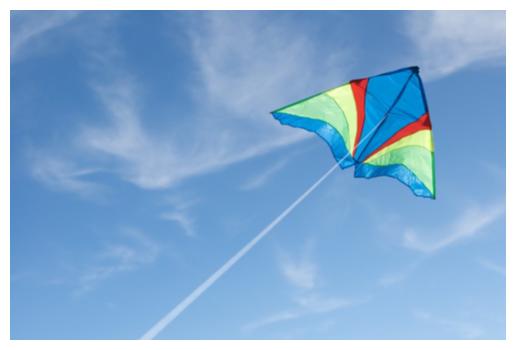

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Foreground


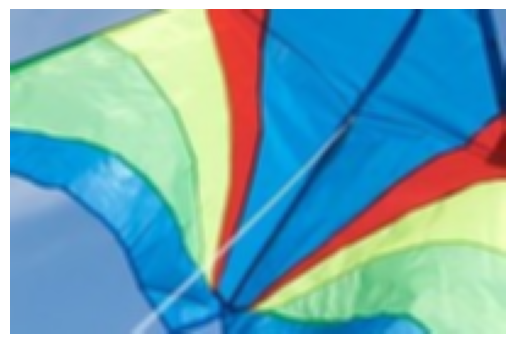

In [5]:
# initalization code

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import cv2

# read images
datadir = "./"
im = cv2.imread(datadir + 'kite.jpg')  # this is the full image
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)/255
im = cv2.blur(im, (3, 3))

crop = cv2.imread(datadir + 'kite_crop.jpg')  # this is the cropped image
crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)/255
crop = cv2.blur(crop, (3, 3))

# displays a single image
def display_image(im):
  plt.imshow(im)
  plt.axis('off')
  plt.show()

# displays the image, score map, thresholded score map, and masked image
def display_score(im, score_map, thresh):
  display_image(im)
  display_image(np.reshape(score_map, (im.shape[:2])))
  plt.imshow(np.reshape(score_map>thresh, (im.shape[0], im.shape[1])), cmap='gray')
  plt.axis('off')
  plt.show()
  display_image(np.tile(np.reshape(score_map>thresh, (im.shape[0], im.shape[1], 1)), (1,1,3))*im)

print('Whole image')
display_image(im)

print('Foreground')
display_image(crop)


In [6]:
print(im.shape)
print(crop.shape)

(532, 799, 3)
(133, 203, 3)


#### Method 1 (per channel hist)

In [7]:
# estimate discrete pdf
def estimate_discrete_pdf(values, nvalues, prior=1):
   '''
   Estimate P(values=v) for each possible v in (0, nvalues)
   Input:
      values: the values of the data
      nvalues: range of values, such that 0 <= values < nvalues
      prior: initial count used to prevent any value from having zero probability
   Output:
      p[nvalues,]: P(values=v) for each v
   '''
# TO DO
   p = np.ones(nvalues)*prior
   for v in values:
      p[v] += 1
   ptotal = p.sum()
   for v in range(len(p)):
      p[v] = p[v] / ptotal 
   return p

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


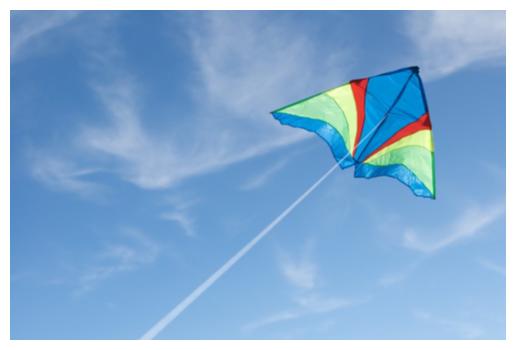

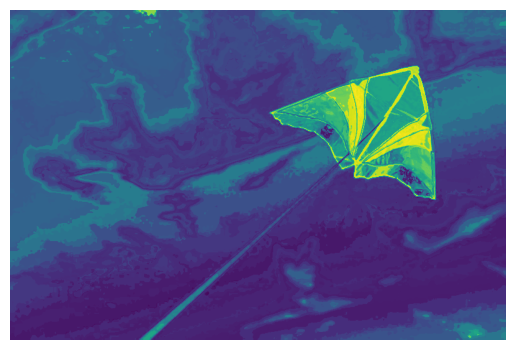

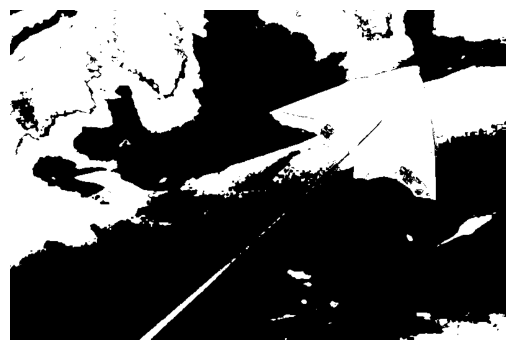

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


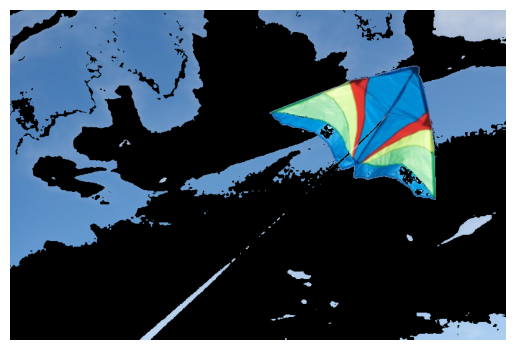

In [8]:
# reshape so number of rows is number of pixels and number of columns is 3 (for RGB)
im_3 = np.reshape(im, (im.shape[0]*im.shape[1], 3))
crop_3 = np.reshape(crop, (crop.shape[0]*crop.shape[1], 3))

# estimate PDFs and compute score per pixel

# TO DO
def discretize(x, nb):
  bins = np.array(range(nb+1))*(1/nb)
  xd = np.zeros(x.shape, dtype='uint32')
  for i in range(1, len(bins)):
    xd += x > bins[i]
  xd[xd<0] = 0
  xd[xd>len(bins)-2]=len(bins)-2
  return xd

bins = 40
c1 = estimate_discrete_pdf(discretize(crop_3[:,0], bins), bins)
c2 = estimate_discrete_pdf(discretize(crop_3[:,1], bins), bins)
c3 = estimate_discrete_pdf(discretize(crop_3[:,2], bins), bins)
im_discrete1 = discretize(im_3[:,0], bins)
im_discrete2 = discretize(im_3[:,1], bins)
im_discrete3 = discretize(im_3[:,2], bins)
i1 = estimate_discrete_pdf(im_discrete1, bins)
i2 = estimate_discrete_pdf(im_discrete2, bins)
i3 = estimate_discrete_pdf(im_discrete3, bins)
Numerator = c1[im_discrete1]*c2[im_discrete2]*c3[im_discrete3]
Denominator = i1[im_discrete1]*i2[im_discrete2]*i3[im_discrete3]
score = np.log(Numerator/Denominator)
t = -2
display_score(im=im, score_map=score, thresh=t)

In [12]:
print(c1[im_discrete1].shape)
print(c1.shape)
print(im_discrete1.shape)

(425068,)
(40,)
(425068,)


#### Method 2 (Kmeans)

In [61]:
# init
!apt install libomp-dev > /dev/null 2>&1
!pip install faiss-cpu > /dev/null 2>&1
import faiss

Sampling a subset of 51200 / 425068 for training
Clustering 51200 points in 3D to 200 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.01 s
  Iteration 19 (0.03 s, search 0.02 s): objective=16.6304 imbalance=1.225 nsplit=0       


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


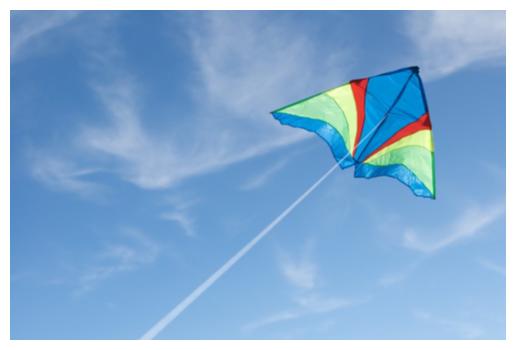

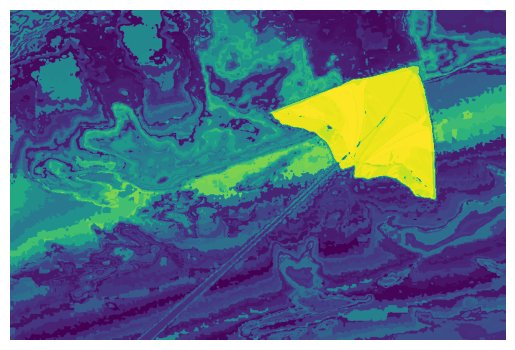

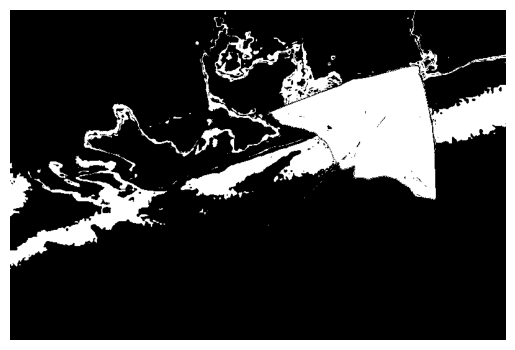

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


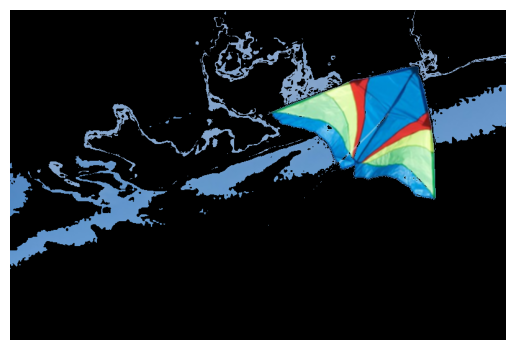

In [65]:
# reshape so number of rows is number of pixels and number of columns is 3 (for RGB)
im_3 = np.reshape(im, (im.shape[0]*im.shape[1], 3))
crop_3 = np.reshape(crop, (crop.shape[0]*crop.shape[1], 3))

# estimate PDFs and compute score per pixel

# TO DO
ncentroids = 200
niter = 20
verbose = True
d = im_3.shape[1]
kmeans = faiss.Kmeans(d, ncentroids, niter=niter, verbose=verbose)
kmeans.train(im_3)
D, I = kmeans.index.search(im_3, 1)
D, C = kmeans.index.search(crop_3, 1)
PDF_im = estimate_discrete_pdf(I, ncentroids)
PDF_crop = estimate_discrete_pdf(C, ncentroids)
Numerator = PDF_crop[I]
Denominator = PDF_im[I]
score = np.log(Numerator/Denominator)
t= -1
display_score(im=im, score_map=score, thresh=t)

#### Method 3 (GMM)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


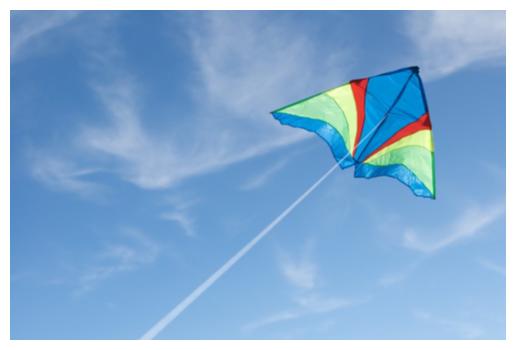

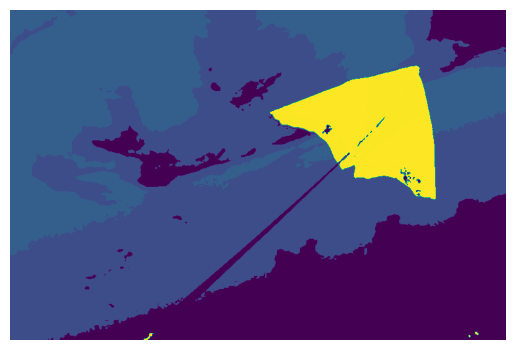

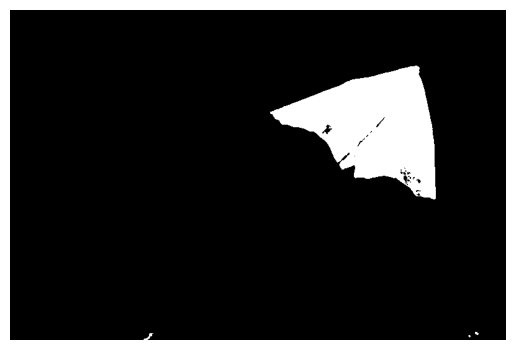

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


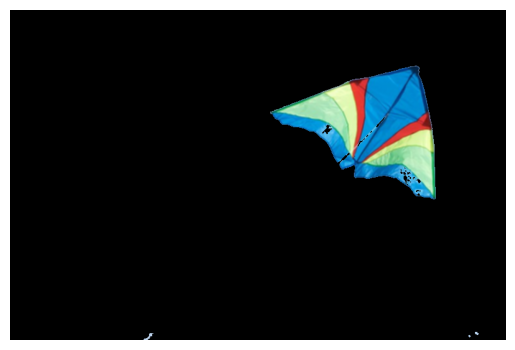

In [66]:
from sklearn.mixture import GaussianMixture

# reshape so number of rows is number of pixels and number of columns is 3 (for RGB)
im_3 = np.reshape(im, (im.shape[0]*im.shape[1], 3))
crop_3 = np.reshape(crop, (crop.shape[0]*crop.shape[1], 3))


# estimate PDFs and compute score per pixel (can use gmm.score_samples where gmm is the mixture model)

# TO DO
gm = GaussianMixture(n_components=5, covariance_type='diag').fit(im_3)
I = gm.predict(im_3)
C = gm.predict(crop_3)
PDF_im = estimate_discrete_pdf(I, ncentroids)
PDF_crop = estimate_discrete_pdf(C, ncentroids)
Numerator = PDF_crop[I]
Denominator = PDF_im[I]
score = np.log(Numerator/Denominator)
t= -1
display_score(im=im, score_map=score, thresh=t)

## Part 2: Robust Estimation

In [1]:
import numpy as np
from matplotlib import pyplot as plt

# load data
T = np.load('./salary.npz')
(salary, years, school) = (T['salary'], T['years'], T['school'])

#### 1. No noise
Compute the statistics for the data as a whole

In [2]:
# TO DO
salary = np.array(salary)
salary_mu = np.mean(salary)
salary_std = np.std(salary)
salary_min = np.min(salary)
salary_max = np.max(salary)

print('Mean: {}  Std: {}  Min: {}   Max: {}'.format(salary_mu, salary_std, salary_min, salary_max))

Mean: 123749.835  Std: 61953.77348723623  Min: 64694.0   Max: 611494.0


#### 2. Percentiles
Assume valid data will fall between the 5th and 95th percentile.

In [3]:
pct = 0.05

# TO DO
newmin = np.percentile(salary, 5)
newmax = np.percentile(salary, 95)
new_salary = salary[(salary<=newmax)&(salary>=newmin)]
salary_mu = np.mean(new_salary)
salary_std = np.std(new_salary)
salary_min = newmin-(newmax-newmin)*0.05/0.9
salary_max = newmax+(newmax-newmin)*0.05/0.9
print('Mean: {}  Std: {}  Min: {}   Max: {}'.format(salary_mu, salary_std, salary_min, salary_max))


Mean: 113878.65  Std: 15876.450453939286  Min: 75493.8   Max: 159900.79999999973


#### 3. EM
Assume valid data follows a Gaussian distribution, while the fake data has a uniform distribution between the minimum and maximum value of salary.

In [42]:
pz = 0.5
valid = np.copy(salary)
mean = np.mean(valid)
std = np.std(valid)
max = np.max(valid)
min = np.min(valid)
for i in range(5):
    p_wrong = 1/(max-min)*(1-pz)
    p_valid = 1/np.sqrt(2*np.pi)/std * np.exp(-1/2 * (valid-mean)**2 /std**2)*pz
    p = p_valid/(p_valid+p_wrong)
    print('Mean: {}  Std: {}  Min: {}   Max: {}'.format(mean, std, np.min(valid[p>0.5]), np.max(valid[p>0.5])))
    # valid = valid[p>0.5]
    # salary_mu = np.mean(valid)
    # salary_std = np.std(valid)
    # salary_min = np.min(valid)
    # salary_max = np.max(valid)
    # print('Mean: {}  Std: {}  Min: {}   Max: {}'.format(salary_mu, salary_std, salary_min, salary_max))
    # print the first five indices of salaries that are not likely to be valid
    print(np.where(p<0.5)[0][:5])
    pz = np.mean(p)
    mean = np.mean(p*valid)
    temp = 0
    for a in range(200):
        temp += p[a]*(valid[a] - mean)**2
    std = np.sqrt(temp / np.sum(p))

Mean: 123749.835  Std: 61953.77348723623  Min: 64694.0   Max: 199353.0
[ 18  28  49 127 128]
Mean: 83456.780740992  Std: 35915.83239719694  Min: 64694.0   Max: 169008.0
[ 18  28  49 127 128]
Mean: 96684.91510579962  Std: 23172.129049621002  Min: 64694.0   Max: 154979.0
[ 18  28  49 127 128]
Mean: 102597.03796985369  Std: 19857.167495715174  Min: 64694.0   Max: 154979.0
[ 18  28  49 127 128]
Mean: 104384.21190134677  Std: 19257.016158689916  Min: 64694.0   Max: 154979.0
[ 18  28  49 127 128]


## Part 4: Stretch Goals
Include all your code used for any stretch goals in this section. Add headings where appropriate.

In [68]:
# TO DO (optional)
arr_salary = salary[school==4294967295]
arr_school = np.zeros((arr_salary.shape[0], 3))
mean0, std0 = np.mean(salary[school==0]), np.std(salary[school==0])
mean1, std1 = np.mean(salary[school==1]), np.std(salary[school==1])
mean2, std2 = np.mean(salary[school==2]), np.std(salary[school==2])
arr_school[:,0] = 1/np.sqrt(2*np.pi)/std0 * np.exp(-1/2 * (arr_salary-mean0)**2 /std0**2)
arr_school[:,1] = 1/np.sqrt(2*np.pi)/std1 * np.exp(-1/2 * (arr_salary-mean1)**2 /std1**2)
arr_school[:,2] = 1/np.sqrt(2*np.pi)/std2 * np.exp(-1/2 * (arr_salary-mean2)**2 /std2**2)

# arr_sum = np.sum(arr_school, axis=1)
# arr_school[:,0] /= arr_sum
# arr_school[:,1] /= arr_sum
# arr_school[:,2] /= arr_sum

school[np.where(school==4294967295)] = np.argmax(arr_school, axis=1)
print(f"overall: {np.mean(salary)}, UIUC mean:{np.mean(salary[school==0])}, MIT mean:{np.mean(salary[school==1])}, Cornell mean:{np.mean(salary[school==2])}")


overall: 123749.835, UIUC mean:120045.63095238095, MIT mean:125265.80701754386, Cornell mean:127559.03389830509


In [71]:
gap = np.zeros((20))
for year in range(20):
  gap[year] = np.mean(salary[years==(year+1)]) - np.mean(salary[years==year])
print(np.mean(gap))

4153.171666666667


In [97]:
from sklearn import datasets
data = datasets.load_diabetes(scaled=False)
x = data['data']
y = data['target']
age = x[:,0]
sex = x[:,1]
mutual_info = 0
for a in set(age):
  for s in set(sex):
    p_x_y = np.sum((age==a) & (sex==s))/age.shape[0]
    if p_x_y:
      p_x = np.sum(age==a)/age.shape[0]
      p_y = np.sum(sex==s)/sex.shape[0]
      # print(f"p_x_y={p_x_y},p_x={p_x},p_y={p_y}")
      mutual_info += p_x_y * np.log(p_x_y/p_x/p_y)
print(mutual_info)

0.09259264627746928
